In [1]:
import pickle
import plotly.graph_objects as go
from copy import copy, deepcopy
from pprint import pprint
from Geometry3D import Point, distance, HalfLine, Plane
import Geometry3D
import gcline
from importlib import reload

#import numpy as np
#suppress scientific notation
#np.set_printoptions(suppress=True, precision=8)
#import parsers.cura4
#from parsers import cura4

import threader, geometry_helpers, gcode, gcline, tlayer, util, cura4layer, lablogging, rich_output_handler, logger, plot_styles
from geometry_helpers import GPoint
from threader import Threader
from tlayer import TLayer
from util import find, GCodeException
from danutil import dupcount
import plot_helpers, plotting, plot_styles
from plotting import plot_steps
import geometry.utils

#Attempt to reload modules automatically
%load_ext autoreload
%autoreload 2

reload threader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Fusion: smaller complex shape v1
gcode_file = '/Users/dan/r/thread_printer/stl/test2/Smaller complex shape - cura.gcode'
cura_project = '/Users/dan/r/thread_printer/stl/test2/Smaller complex shape - cura.3mf'
# From cura4.parse_3mf(cura_project) so I don't have to run that every time
thread_transform = np.array([39.26039839, 46.27034378, 23.87050056])
#See thread_from_fusion.py to get thread path
tpath = [
		([33.7300, 17.1077, 11.4653], [56.0477, 43.4545, 11.4653]),
		([56.0477, 43.4545, 11.4653], [53.2410, 59.2656, 11.4653]),
		([53.2410, 59.2656, 11.4653], [26.9901, 69.3288, 42.0560]),
		([26.9901, 69.3288, 42.0560], [26.9901, 69.3288, 47.7410]),
]

In [2]:
gcode_file = '/Users/dan/r/thread_printer/stl/test3/Router test-cura5.gcode'
cura_project = '/Users/dan/r/thread_printer/stl/test3/Router test-cura5.3mf'
#thread_transform = np.array([27.43560219, 27.43383789,  5.0])
tpath = [
	([18.2689, 14.9338, 3.3333], [18.2689, 36.6005, 3.3333]),
	([18.2689, 36.6005, 3.3333], [36.6023, 36.6005, 3.3333]),
	([36.6023, 36.6005, 3.3333], [36.6023, 18.2672, 3.3333]),
	([36.6023, 18.2672, 3.3333], [21.6023, 18.2672, 3.3333]),
	([21.6023, 18.2672, 3.3333], [21.6023, 21.6005, 6.6667]),
	([21.6023, 21.6005, 6.6667], [21.6023, 36.6005, 6.6667]),
	([21.6023, 36.6005, 6.6667], [33.2689, 36.6005, 6.6667]),
	([33.2689, 36.6005, 6.6667], [33.2689, 21.6005, 6.6667])
]

In [ ]:
thread_transform = cura4.parse_3mf(cura_project)
thread_transform

In [17]:
#tpath = np.array(tpath)

#Do it this way so I can add transform if needed
#tpath = np.insert(tpath, 0, [[0,0,0], tpath[0,0]], axis=0)

#Temporary fix for TODO in cura4.parse3mf
#thread_transform[2] = 0

g = gcode.GcodeFile(gcode_file, layer_class=TLayer)
t = Threader(g)

#start_layer = next(layer for layer in g.layers if (layer.z + layer.layer_height) >= tpath[0][1][2])
#start_layer = g.layers[56]

thread_geom = list([geometry_helpers.GSegment(GPoint(*s), GPoint(*e)) for s,e in tpath])

In [18]:
t.route_model(thread_geom)

Accordion()

Preview of 18 steps for layer 32


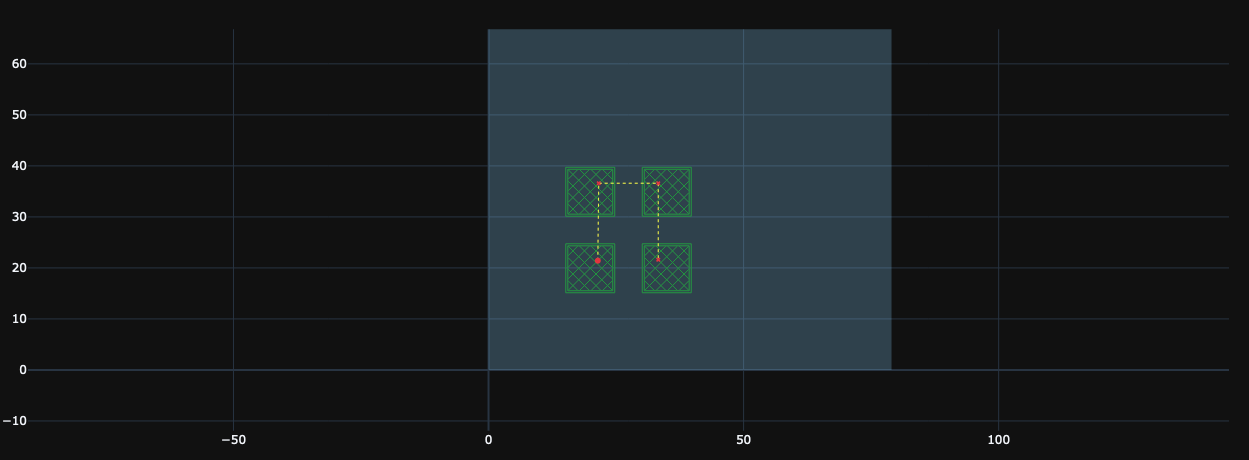

Step 0: Move thread to avoid 1 segments fixing start anchor


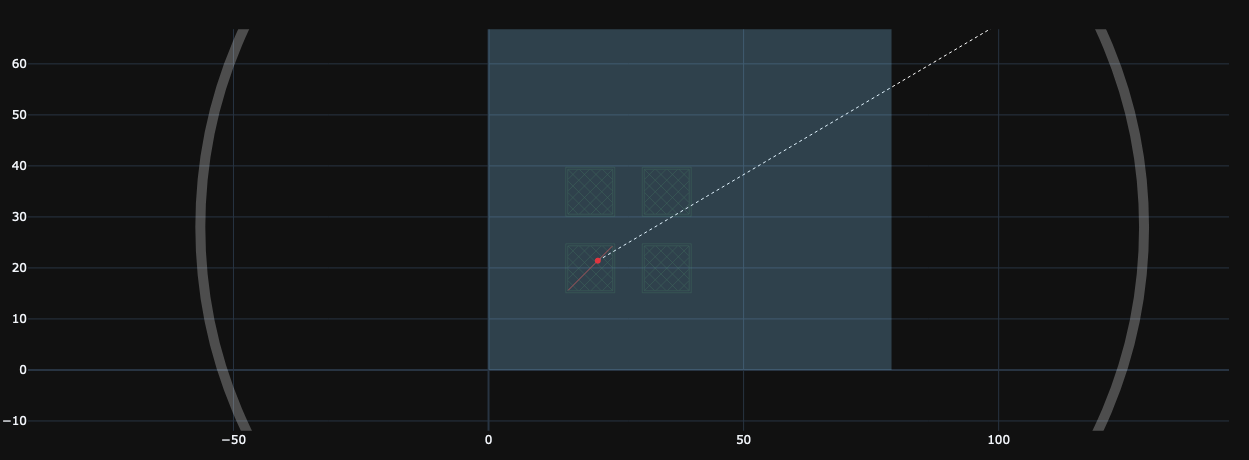

Step 1: Print 1 anchor-fixing segments


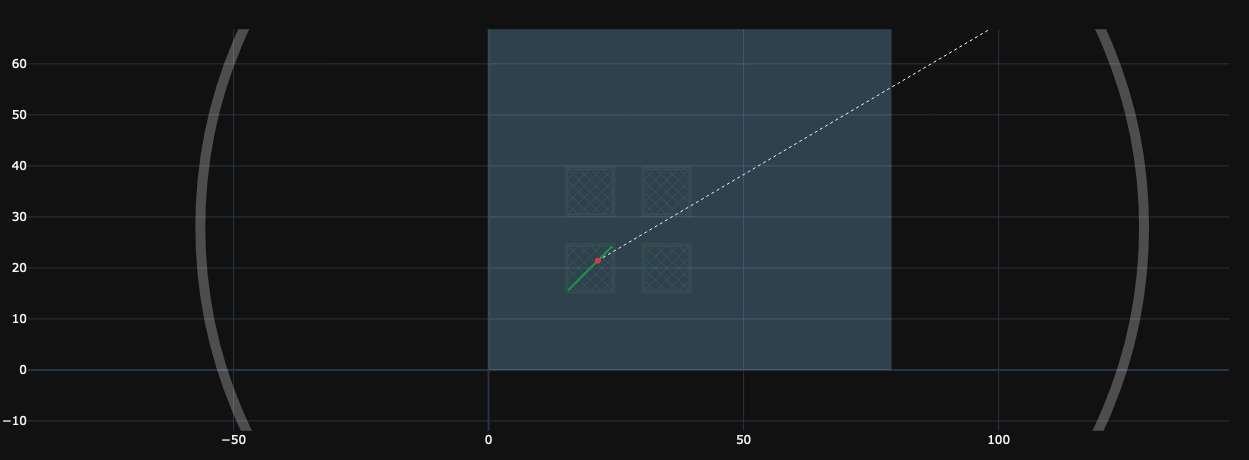

Step 2: Move thread to avoid 56 segments


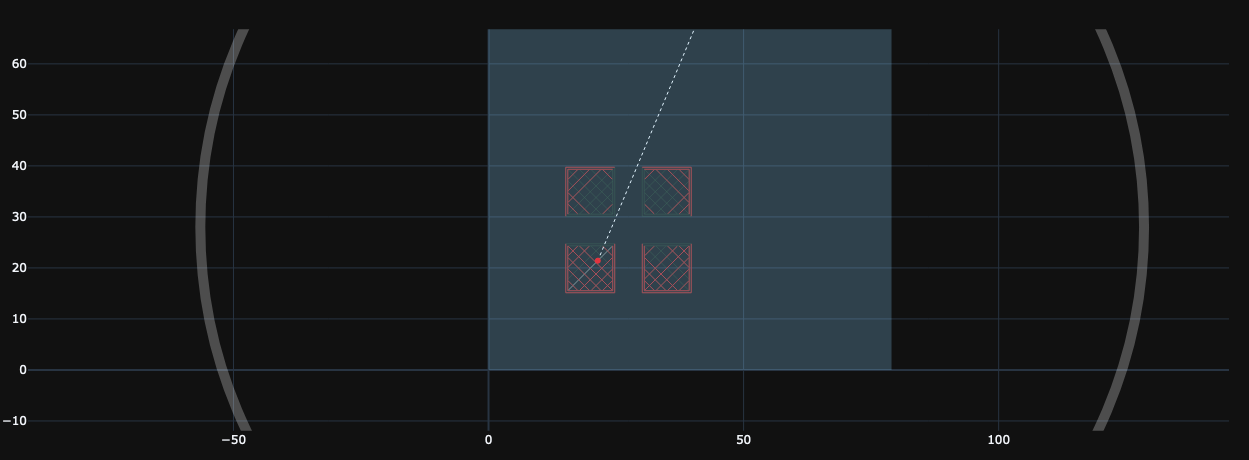

Step 3: Print 55 segments thread doesn't intersect


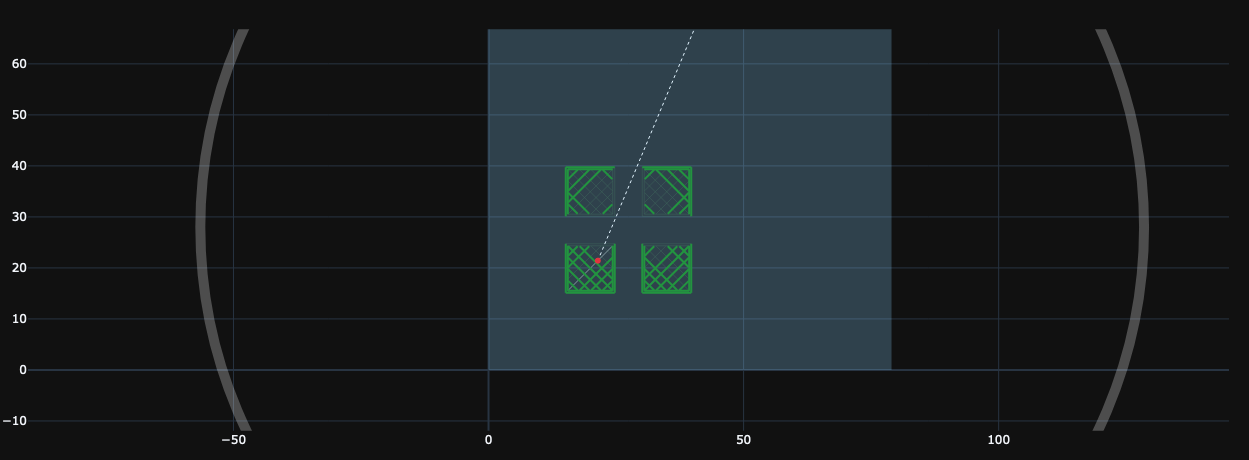

Step 4: Move thread to avoid 1 segments


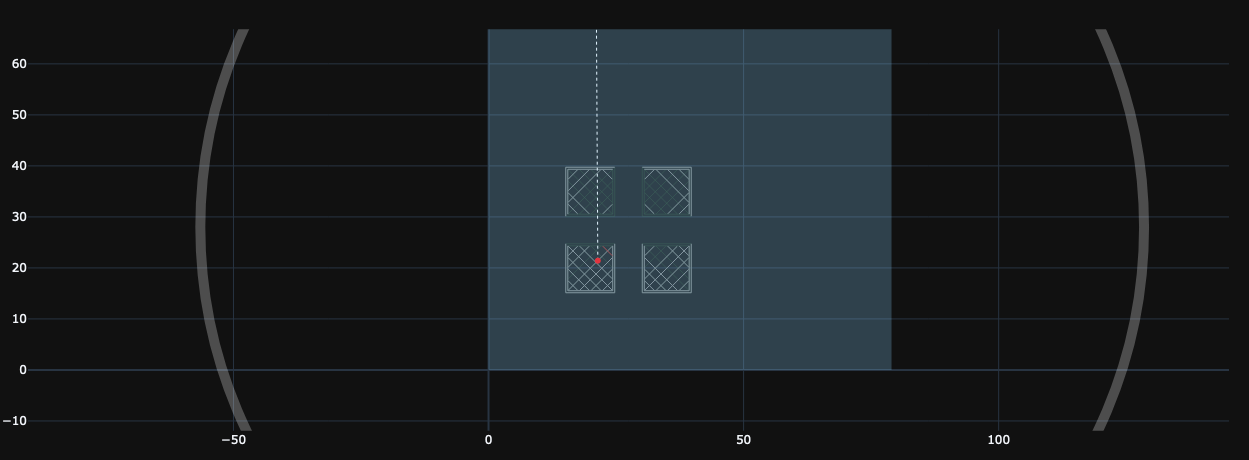

Step 5: Print 1 segments thread doesn't intersect


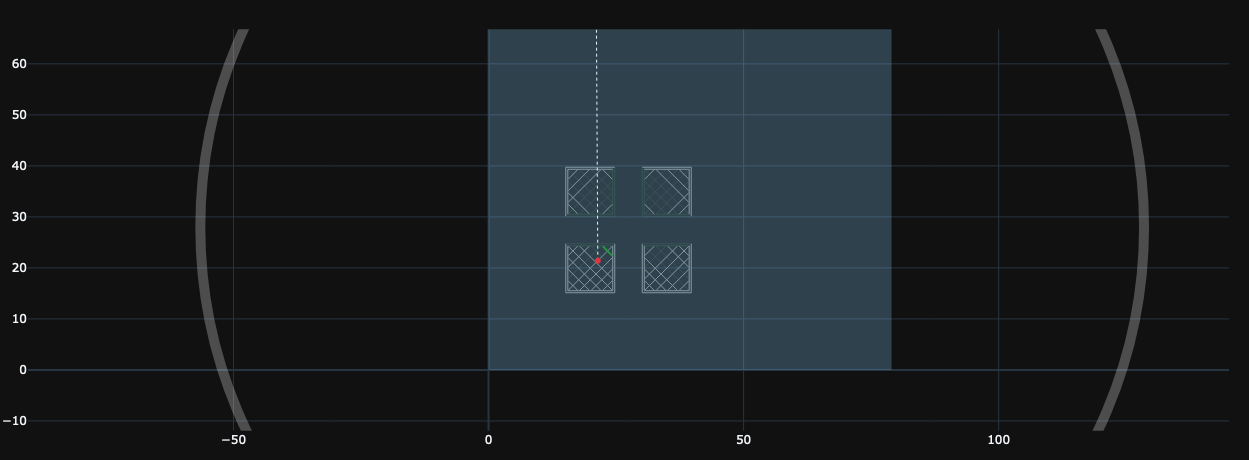

Step 6: Move thread to overlap anchor at { 21.60,  36.60,   6.60}


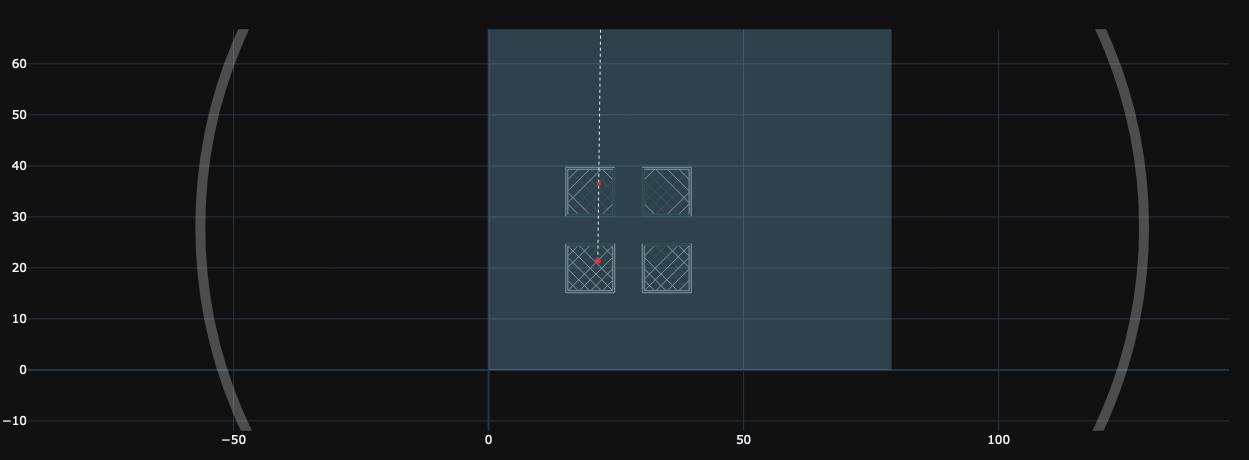

Step 7: Print 1 segment to fix anchor


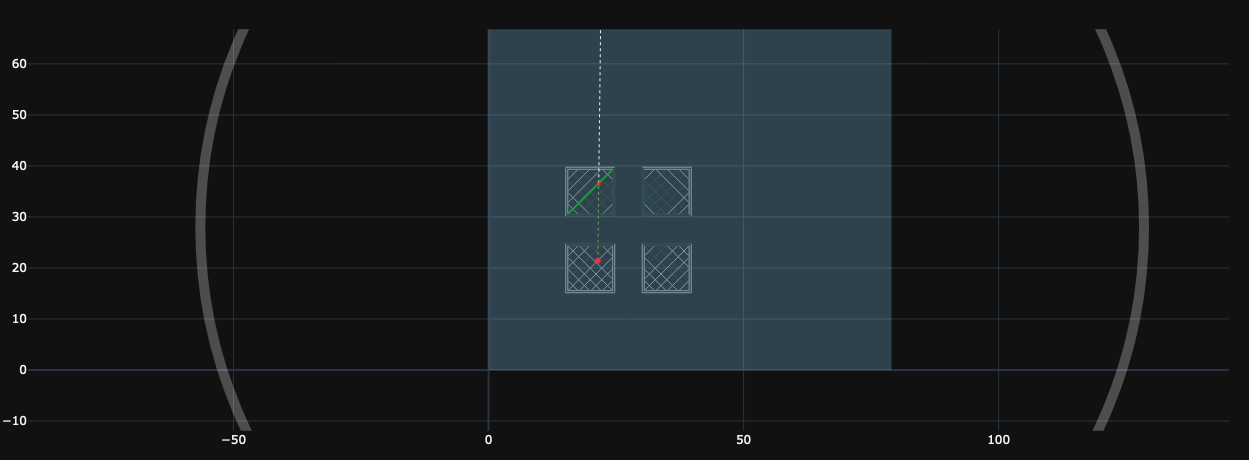

Step 8: Move thread to avoid 10 segments


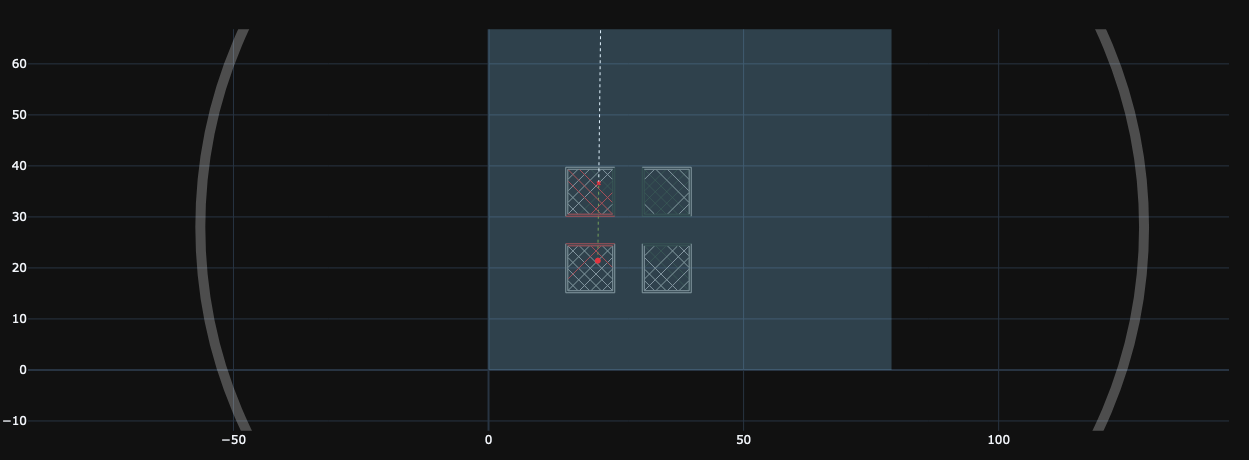

Step 9: Print 10 segments thread doesn't intersect


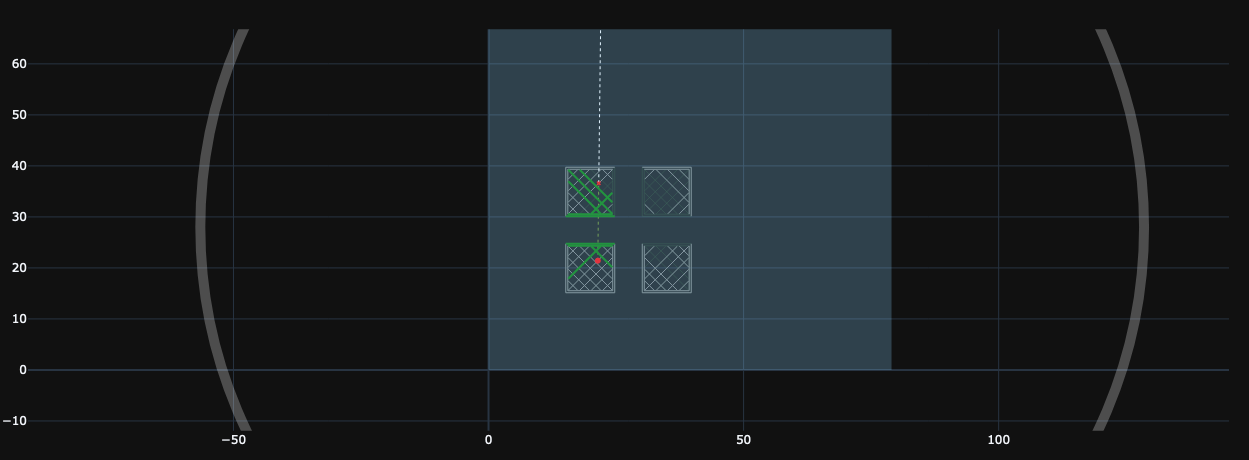

Step 10: Move thread to overlap anchor at { 33.27,  36.60,   6.60}


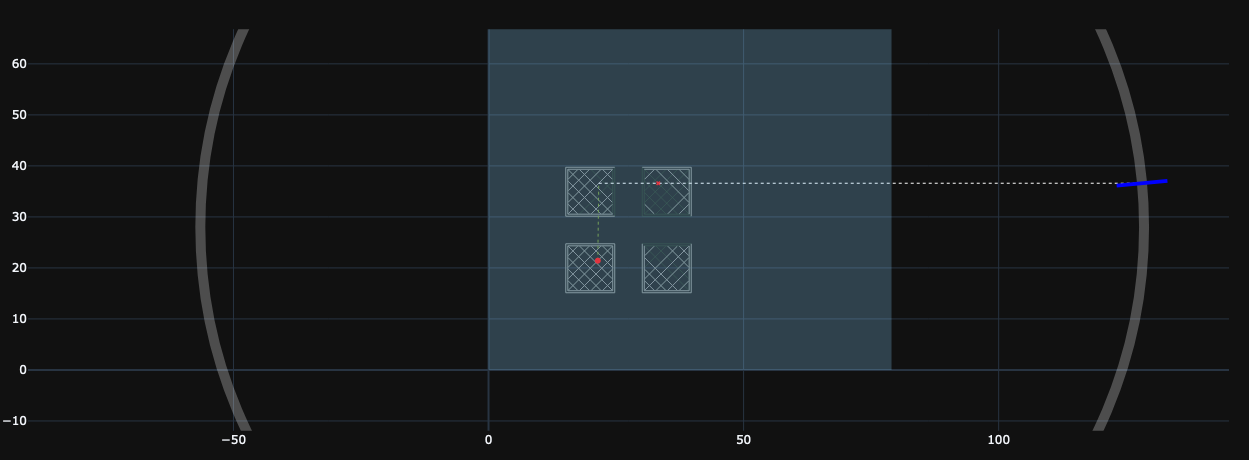

Step 11: Print 1 segment to fix anchor


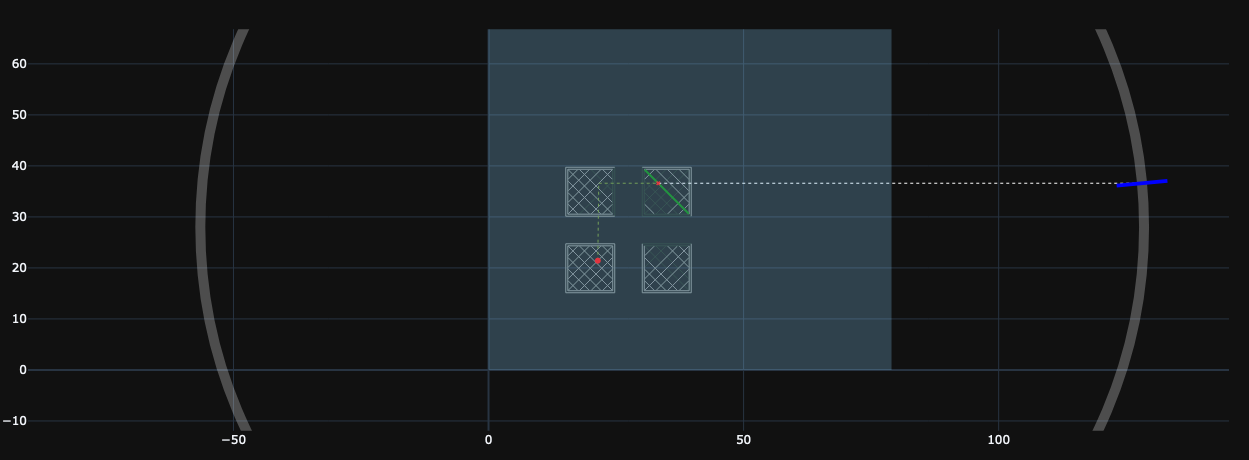

Step 12: Move thread to avoid 7 segments


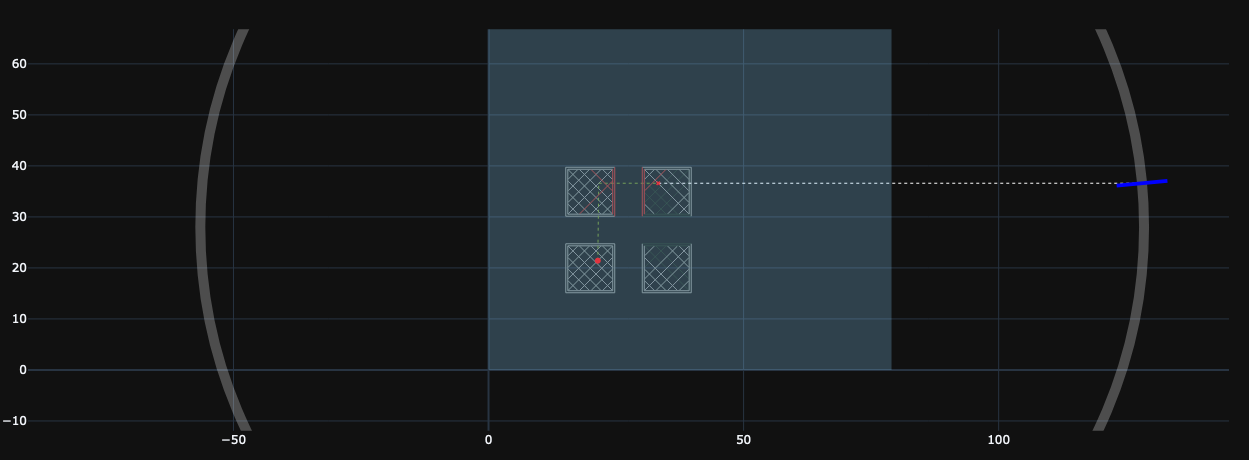

Step 13: Print 7 segments thread doesn't intersect


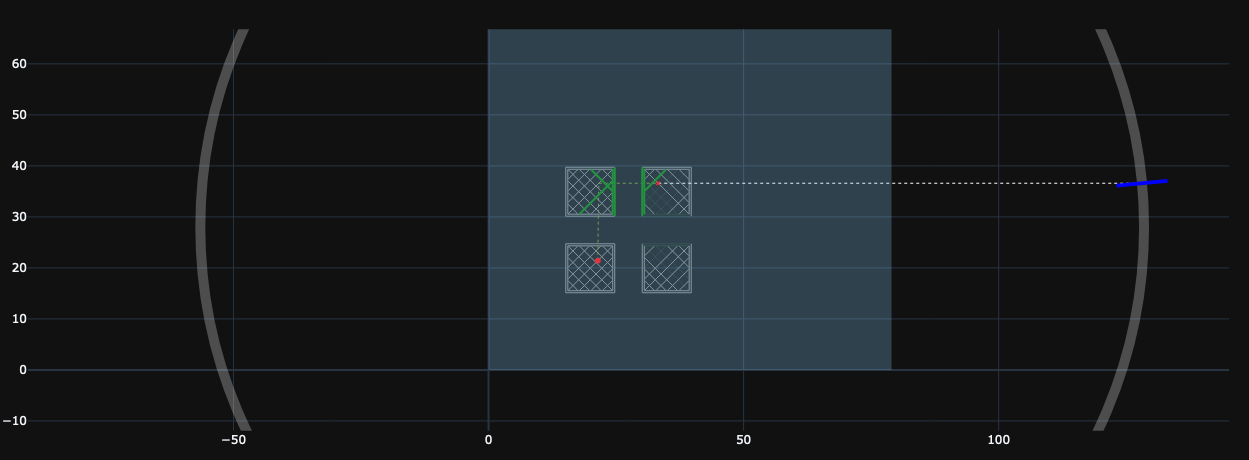

Step 14: Move thread to overlap anchor at { 33.27,  21.60,   6.60}


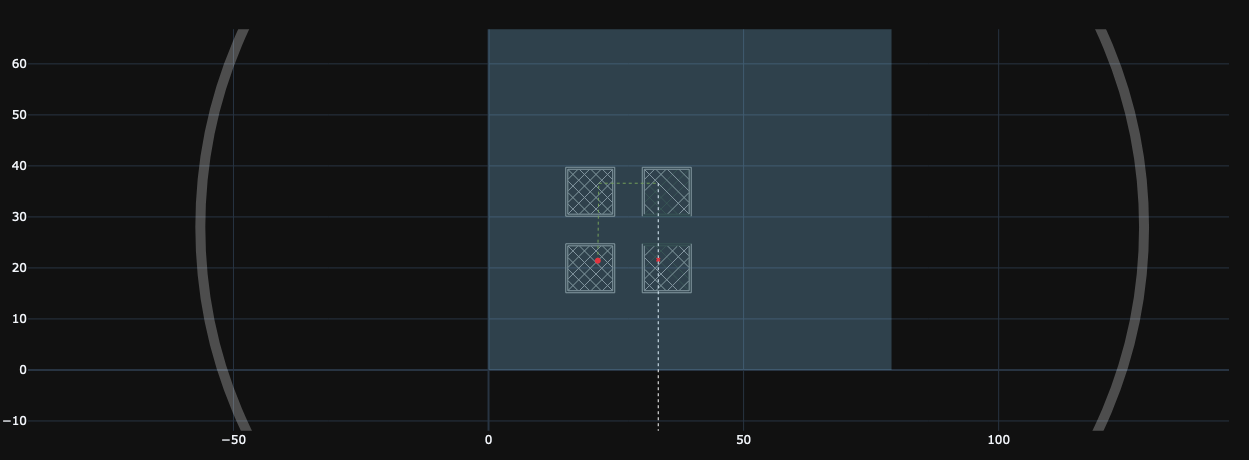

Step 15: Print 1 segment to fix anchor


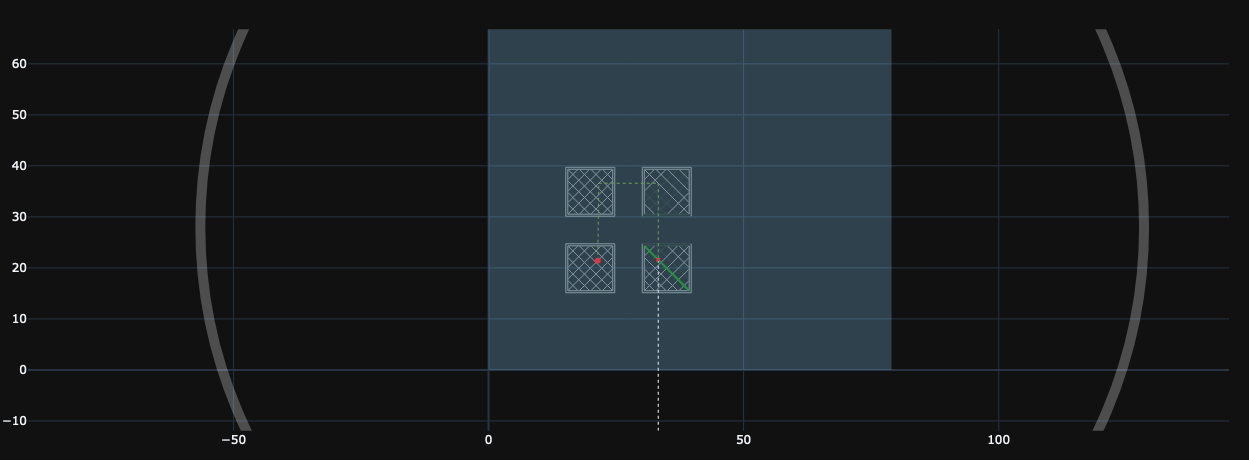

Step 16: Move thread to avoid 11 segments


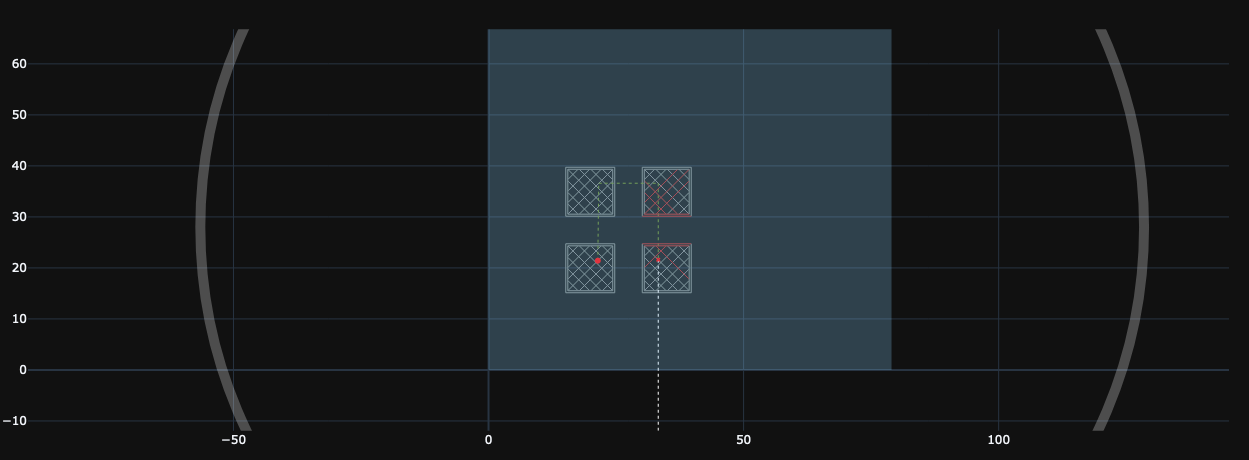

Step 17: Print 11 segments thread doesn't intersect


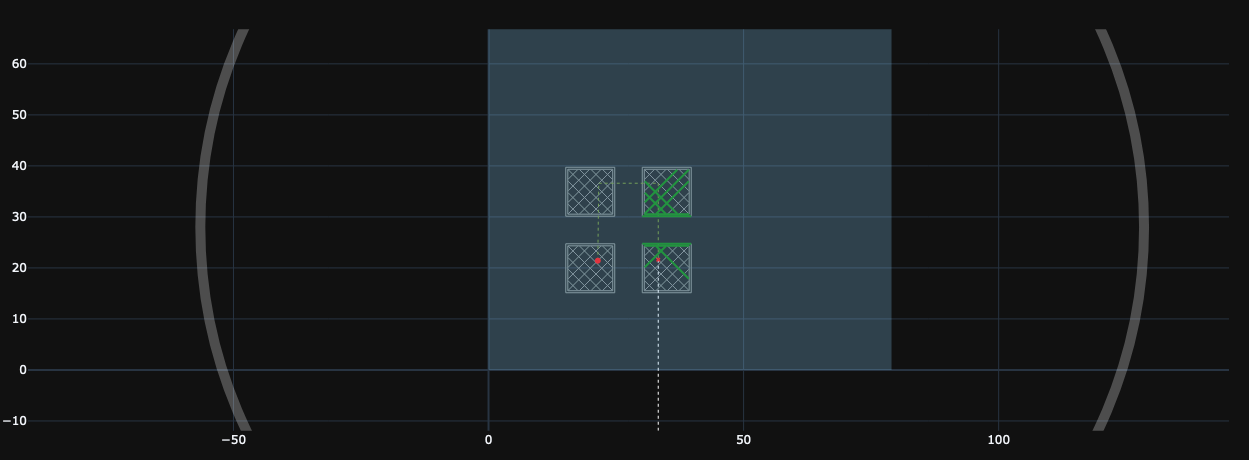

Finished routing this layer


In [19]:
l = 32
#reload(plot_styles)
#reload(plotting)
#plotting.styles = plot_styles.styles
plotting.plot_steps(t.layer_steps[l], prev_layer=g.layers[l-1], prev_layer_only_outline=False)

In [40]:
t.layer_steps[16].steps[1].printer.anchor

{  0.00,   0.00,   3.40}

Step 0: Move thread to avoid 1 segments fixing start anchor

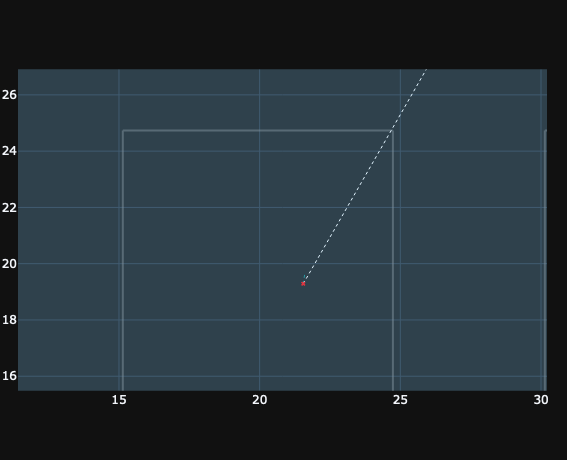

Step 1: Print 1 anchor-fixing segments

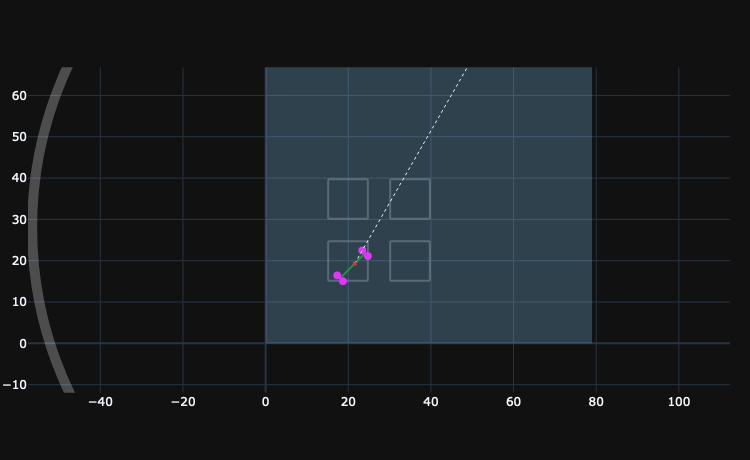

Step 2: Move thread to avoid 87 segments

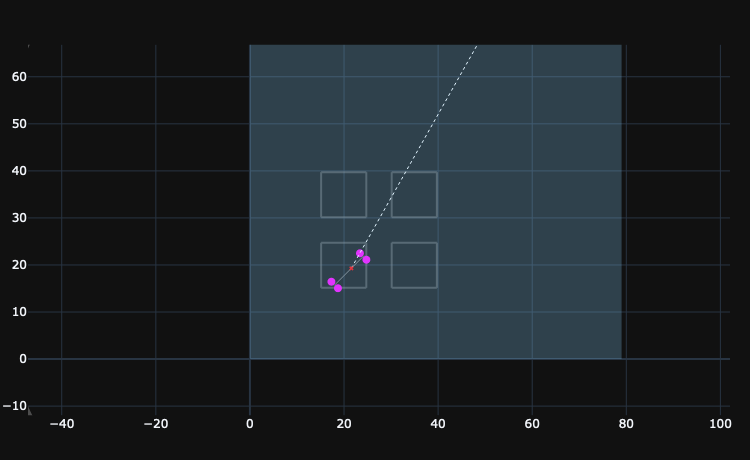

Step 3: Print 74 segments thread doesn't intersect

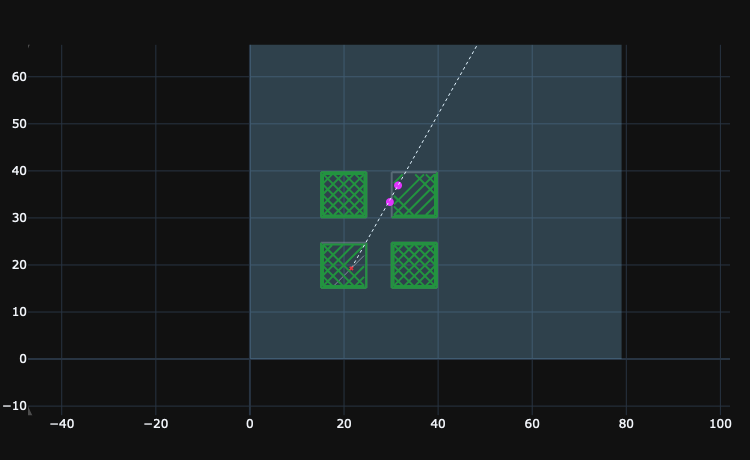

Step 4: Move thread to avoid 13 segments

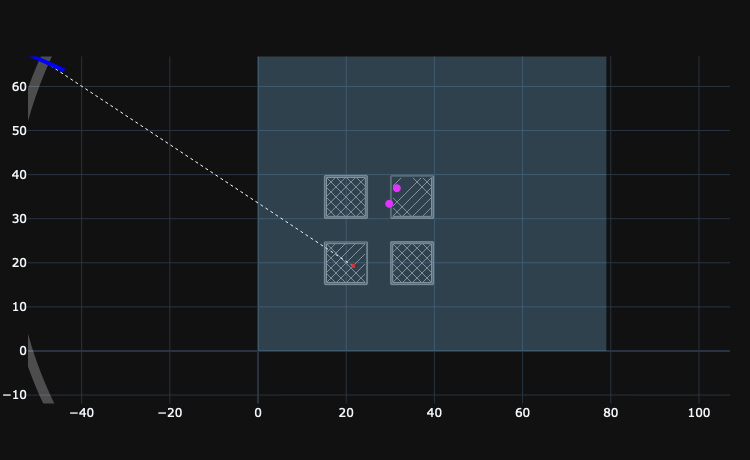

Step 5: Print 2 segments thread doesn't intersect

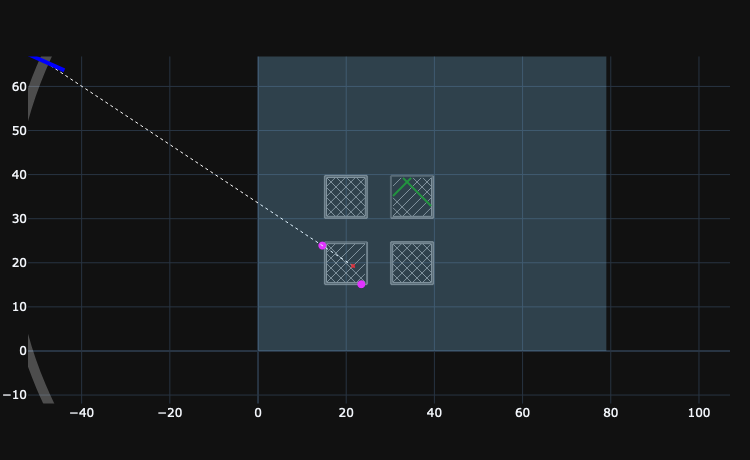

Step 6: Move thread to avoid 11 segments

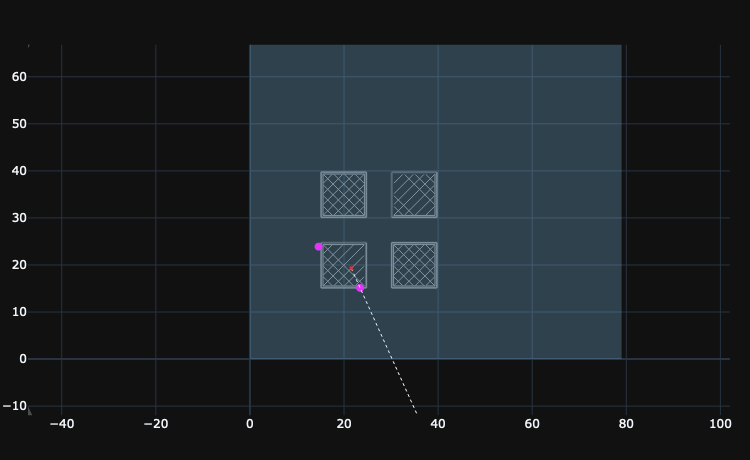

Step 7: Print 11 segments thread doesn't intersect

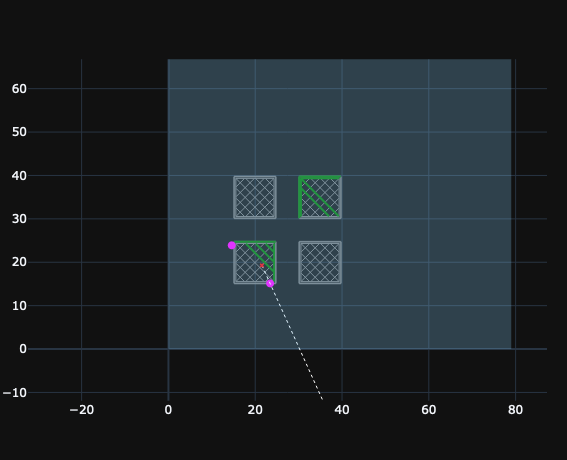

Step 8: Move thread to overlap anchor at { 21.75,  19.49,   4.60}

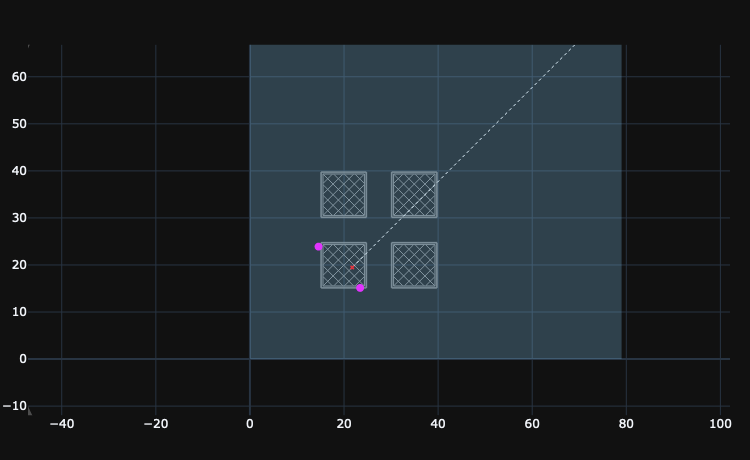

Finished routing this layer

In [27]:
t.layer_steps[22].plot(prev_layer=g.layers[21])

<Step 12 [light_sea_green italic]Move thread to avoid remaining geometry[/]
  Printer(⚓︎{ 21.60,  18.27,   3.40}, ⌾ -160.98°)


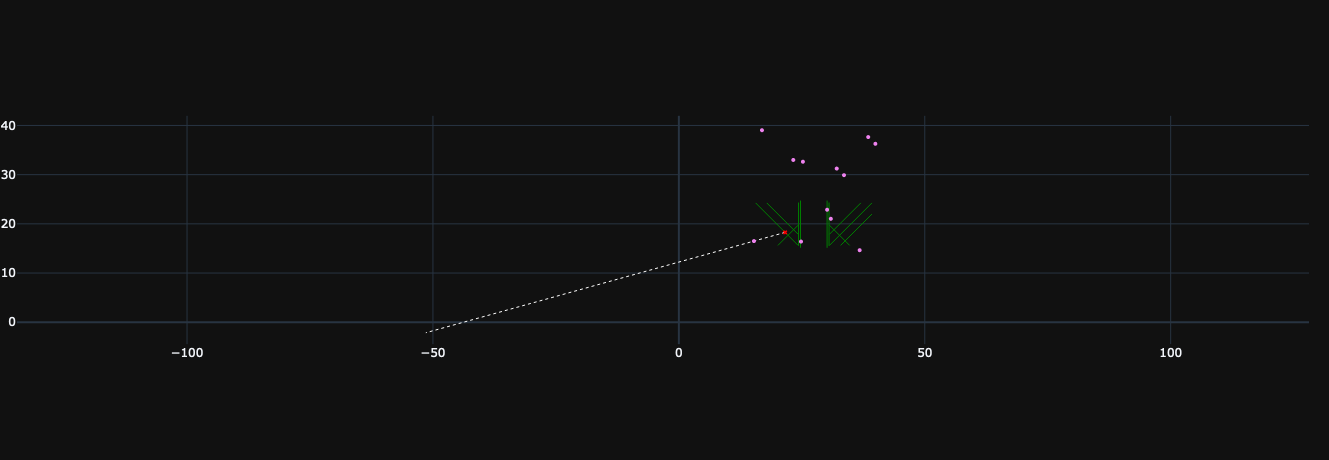

In [12]:
lls = t.layer_steps[-1].steps[12]
llsp = lls.printer
print(lls)
fig = plot_helpers.quickplot(
    gc_segs=llsp.debug_avoid,
    anchor= llsp.anchor,
    thread= llsp.anchor_to_ring(),
    points= llsp.debug_non_isecs,
)

In [13]:
pickle.dump([llsp.debug_avoid, llsp.anchor_to_ring()], open('/tmp/l16avoid.pickle', 'wb'))

In [70]:
sizes = []
for name in dir():
    if name[:2] == '__': continue
    thing = locals()[name]
    if (size := asizeof(thing)) < 1000: continue
    sizes.append([name, size, type(thing)])

In [77]:
for x in sorted(sizes, key=lambda a:a[1], reverse=True):
    name, size, t = x
    t = str(t).replace("<class '", '').replace("'>", '')
    print(f'{name}\t\t{size:>12,}\t{t}')

threader		  72,604,312	module
tlayer		  72,603,008	module
_64		  72,600,080	module
quit		  72,599,912	IPython.core.autocall.ZMQExitAutocall
exit		  72,598,168	IPython.core.autocall.ZMQExitAutocall
g		  10,450,872	gcode.GcodeFile
lls		   7,445,008	threader.Step
llsp		     664,488	threader.Printer
fig		     198,296	plotly.graph_objs._figure.Figure
np		     114,352	module
pd		      55,608	module
pickle		      36,496	module
go		      33,304	module
plot_helpers		      29,840	module
Geometry3D		      28,160	module
geometry_helpers		      27,448	module
util		      24,784	module
gcode		      24,720	module
parsers		      24,592	module
rich_output_handler		      24,432	module
cura4		      24,328	module
gcline		      24,312	module
lablogging		      24,120	module
cura4layer		      23,896	module
In		      18,384	list
_ih		      18,384	list
thread_geom		      14,032	list
Out		       8,240	dict
_oh		       8,240	dict
_52		       7,696	list
sizes		       4,744	list


In [84]:
import pympler.asizeof
print(pympler.asizeof.asized(threader.acclog, detail=5).format())

/opt/homebrew/lib/python3.10/site-packages/pympler/asizeof.py:690: UserWarning:

Iterating '<class 'traitlets.config.loader.Config'>': TypeError("'LazyConfigValue' object is not iterable")



<AccordionHandler (NOTSET)> size=72641216 flat=48
    __dict__ size=72641168 flat=232
        [V] _accordion: Accordion(children=(Output(layout=Layo....,))), titles=('Layer 16', 'Layer 17')) size=72632752 flat=48
            __dict__ size=72632704 flat=360
                [V] _trait_values: {'children': (Output(layout=Layout(wid....'tooltip': None, '_property_lock': {}} size=72631176 flat=640
                    [V] children: (Output(layout=Layout(width='100%'), o....</span>\n</pre>'}, 'metadata': {}},))) size=72626272 flat=56
                    [V] layout: Layout() size=3768 flat=48
                    [V] titles: ('Layer 16', 'Layer 17') size=184 flat=56
                    [V] keys: ['_dom_classes', '_model_module', '_mo....dex', 'tabbable', 'titles', 'tooltip'] size=184 flat=184
                    [K] children size=64 flat=64
                    [V] _property_lock: {} size=64 flat=64
                    [K] comm size=0 flat=0
                    [V] comm: <ipykernel.comm.comm.Com